# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

## **Reviews** ##

In [2]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

In [3]:
data_reviews = pd.DataFrame(data_reviews)

In [4]:
data_reviews.head(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,NaN


In [5]:
data_reviews.isna().sum()

username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

Conclusión:

Se pueden observar que tanto la variable "products" como "user_id" poseen valores nulos pero, por el otro lado las variables "username" y "product_id" no los poseen, por este motivo utilizaremos en este proyecto las variables "username" y "product_id" ya que no poseen valores nulos.

## **Games** ##

In [6]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [7]:
data_games.head(5)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [8]:
data_games[data_games.id == '35140']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


In [9]:
data_reviews_backup=data_reviews.copy()
data_reviews_backup.head(1)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN


In [10]:
# Solo para Parte C - Investigación
data_reviews_parteC=data_reviews_backup

In [11]:
data_games_backup=data_games.copy()
data_games_backup.head(1)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN


In [12]:
# Solo para Parte C - Investigación
data_games_parteC=data_games_backup

---

### PARTE A: Exploración de Datos ###

## REVIEWS ##

In [13]:
data_user=data_reviews[['username','user_id']]
data_user

,username,user_id
0,Chaos Syren,NaN
1,Ariman1,NaN
2,freakfantom,NaN
3,The_Cpt_FROGGY,76561198003030375
4,the_maker988,76561198353396844
...,...,...
779302,Vidaar,NaN
779303,Nikolai Belinski,NaN
779304,RancorZealot,76561197963920623
779305,Jerry,76561198042664856


Conclusión: 

Podemos observar que hay algunos username que no poseen User ID. Por eso, agruparemos utilizando username, ya que "username" no posee valores nulos.

#### A continuación, nos desharemos de aquellas variables que no son de interes para nuestro análisis ####

In [14]:
data_reviews.drop(['date', 'products','page_order','text','early_access','compensation','found_funny','page', 'user_id'], axis=1, inplace=True)

In [15]:
data_review_filters = data_reviews

In [16]:
data_review_filters.head(10)

,username,hours,product_id
0,Chaos Syren,0.1,725280
1,Ariman1,13.2,328100
2,freakfantom,0.1,725280
3,The_Cpt_FROGGY,7.8,631920
4,the_maker988,8.2,35140
5,Szudof,0.2,288690
6,Vonder,2.7,35600
7,LucaFox,4.0,620900
8,rampage1209,34.8,1840
9,Devil Azite,0.1,671270


#### A continuación, a cada usuario le crearemos su user_id ####

In [17]:
import numpy as np
user=data_review_filters['username'].unique()
user_unique=pd.DataFrame(user,columns=['username'])   
finRango=len(user_unique)+1
user_id=np.array(range(1,finRango,1))
user_unique['user_id']=user_id
user_unique

,username,user_id
0,Chaos Syren,1
1,Ariman1,2
2,freakfantom,3
3,The_Cpt_FROGGY,4
4,the_maker988,5
...,...,...
540336,Seikleja,540337
540337,KindAlcoholic,540338
540338,SepticFalcon,540339
540339,RancorZealot,540340


In [18]:
#Cuantos usuarios unicos hay? 

len(user_unique)

540341

In [19]:
#Unimos el dataset filtrado junto con los usuarios ID
data_review_filters = data_review_filters.merge(user_unique)

In [20]:
data_review_filters

,username,hours,product_id,user_id
0,Chaos Syren,0.1,725280,1
1,Ariman1,13.2,328100,2
2,Ariman1,0.5,521230,2
3,Ariman1,2.0,493980,2
4,freakfantom,0.1,725280,3
...,...,...,...,...
779302,Seikleja,80.8,252490,540337
779303,KindAlcoholic,1303.6,252490,540338
779304,SepticFalcon,334.9,252490,540339
779305,RancorZealot,203.5,252490,540340


En esta grilla se pueden observar los product ids junto con la cantidad de horas de juego que dedicaron los distintos usuarios

### A continuación analizaremos las horas de juego de los usuarios ###

In [21]:
data_review_filters.isna().sum()

username         0
hours         2637
product_id       0
user_id          0
dtype: int64

Podemos observar que la variable "hours" es la unica variable que posee valores nulos.

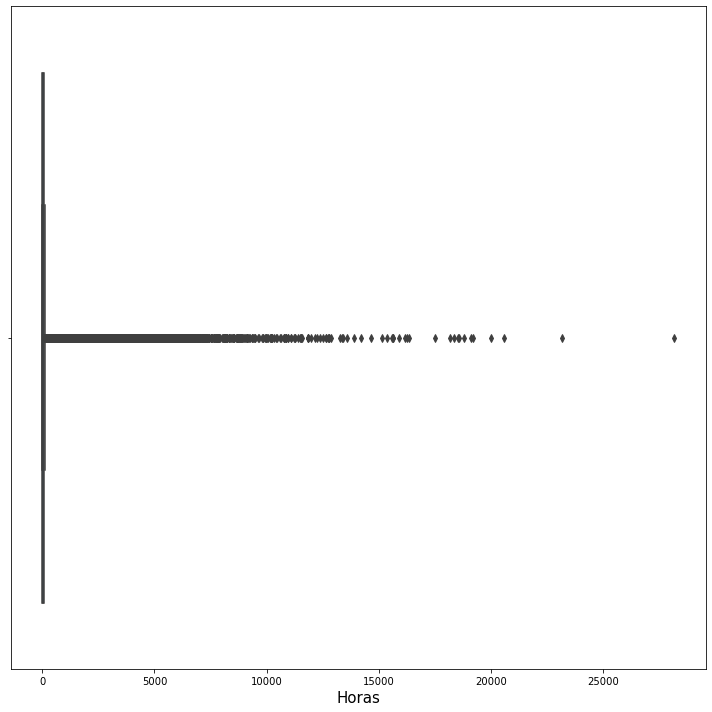

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(10,10))
plt.subplot()
ax = sns.boxplot(data = data_review_filters, x = "hours")
plt.xlabel('Horas', fontsize=15);

plt.tight_layout()
plt.show()

Conclusión:

Podemos observar que existen outliers dentro de las cantidades de horas que juegan los usuarios, asique vamos a analizar más en detalle dichas horas para ver como podemos proceder con ellas. 

In [23]:
#Separamos a los usuarios en 4 grupos segun cantidad de horas jugadas
menorQue10=len(data_reviews[data_reviews.hours<10])
menorQue20=len(data_reviews[(data_reviews.hours>10)&(data_reviews.hours<20)])
mayorQue50=len(data_reviews[(data_reviews.hours>50)&(data_reviews.hours<100)])
mayoresQue100=len(data_reviews[data_reviews.hours>100])

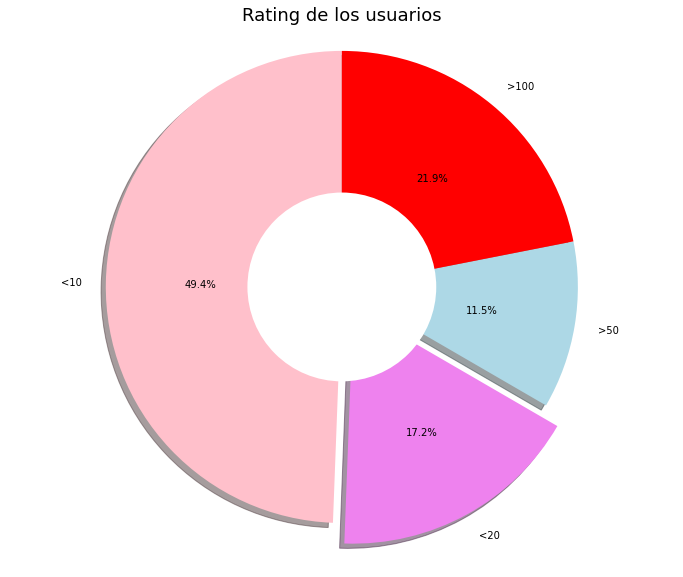

In [24]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['<10', '<20', '>50', '>100']
sizes = [menorQue10, menorQue20, mayorQue50, mayoresQue100]
explode = (0, 0.1, 0, 0)  
colors = ["pink", "violet", "lightblue", "red"]


fig1, ax1 = plt.subplots(figsize=(12, 10), facecolor='white')
ax1.pie(sizes, explode=explode, colors = colors, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Rating de los usuarios', fontsize=18)

centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.show()

Conclusión: 

Claramente las horas mayores a 100 no las podemos tratar como outliers ya que representan casi un 22 % de los datos, por lo que decidimos realizar un escalamiento de los datos para transformar las horas en un rating del 1 al 10 siendo 10 mayor de 100 horas.

In [25]:
# Agregamos una columna denominada "rating" con valor cero.

data_review_filters['rating']=0
data_review_filters.head(5)

,username,hours,product_id,user_id,rating
0,Chaos Syren,0.1,725280,1,0
1,Ariman1,13.2,328100,2,0
2,Ariman1,0.5,521230,2,0
3,Ariman1,2.0,493980,2,0
4,freakfantom,0.1,725280,3,0


El rating estara conformado de la siguiente forma:

* 10: menos de 10 horas
* 20: menos de 20 horas
* 30: menos de 30 horas
* 40: menos de 40 horas
* 50: menos de 50 horas
* 60: menos de 60 horas
* 70: menos de 70 horas
* 80: menos de 80 horas
* 90: menos de 90 horas
* 100: más de 100 horas

In [26]:
rank=[10,20,30,40,50,60,70,80,90]

for valor in rank:
    data_review_filters['rating'][(data_review_filters.hours>(valor-10)) & (data_review_filters.hours<=valor)]=(valor/10)

data_review_filters['rating'][(data_review_filters.hours>=100) ]=10

<ipython-input-26-efd0ec872755>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_review_filters['rating'][(data_review_filters.hours>(valor-10)) & (data_review_filters.hours<=valor)]=(valor/10)
<ipython-input-26-efd0ec872755>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_review_filters['rating'][(data_review_filters.hours>(valor-10)) & (data_review_filters.hours<=valor)]=(valor/10)


In [27]:
# Eliminamos la columna hours pues ya no la necesito mas
data_review_filters.drop(columns=['hours'], inplace=True)

Text(0.5, 1.0, 'Rating')

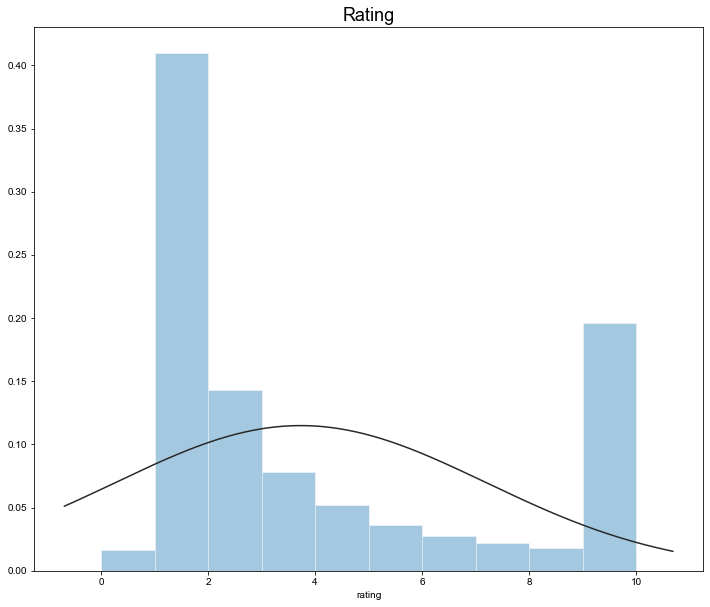

In [31]:
import seaborn as sns
from scipy.stats import norm
plt.subplots(figsize=(12, 10))
sns.set_style("whitegrid")
x = data_review_filters.rating
ax = sns.distplot(x, fit=norm, kde=False, bins=10)
plt.title('Rating', fontsize=18)

Podemos observar la variable "hours" transformada en un ranking que va del 1 al 10 dependiendo de las cantidades de horas que jugaron los usuarios.

In [32]:
#RATING
r1=len(data_review_filters[data_review_filters.rating==1])
r2=len(data_review_filters[data_review_filters.rating==2])
r3=len(data_review_filters[data_review_filters.rating==3])
r4=len(data_review_filters[data_review_filters.rating==4])
r5=len(data_review_filters[data_review_filters.rating==5])
r6=len(data_review_filters[data_review_filters.rating==6])
r7=len(data_review_filters[data_review_filters.rating==7])
r8=len(data_review_filters[data_review_filters.rating==9])
r9=len(data_review_filters[data_review_filters.rating==9])
r10=len(data_review_filters[data_review_filters.rating==10])

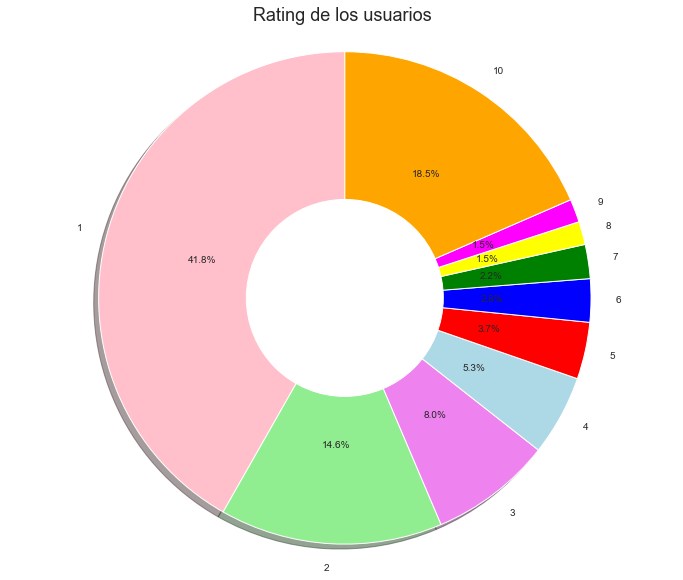

In [34]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [1,2,3,4,5,6,7,8,9,10]
sizes = [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
explode = (0,0,0,0,0,0,0,0,0,0)
colors = ["pink", "lightgreen", "violet", "lightblue", "red", "blue", "green", "yellow", "magenta", "orange"]


fig1, ax1 = plt.subplots(figsize=(12, 10), facecolor='white')
ax1.pie(sizes, colors = colors, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, )
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Rating de los usuarios', fontsize=18)


centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.show()

Conclusión:

Podemos observar que en casi 42% la mayoria de los usuario jugaron menos de 10 horas, seguido en segundo lugar por casi un 19% usuarios que jugaron más de 100 horas, seguido en tercer lugar por un casi 15% de usuarios que jugaron menos de 20 horas. Dejanso así, un total de casi 15% distribuidos entre usuarios que jugaron 30,40,50,60,70,80 horas.

In [35]:
data_review_filters.isna().sum()


username      0
product_id    0
user_id       0
rating        0
dtype: int64

Conclusión:
    
Podemos observar que ya no poseemos ningun valor nulo en nuestras variables.

In [36]:
user_hour_max = data_review_filters.loc[(data_review_filters['rating'] == 10 )]

In [37]:
user_hour_max.head(20)

,username,product_id,user_id,rating
148,Hanzo,287290,16,10
166,Harry,377160,17,10
169,Harry,440,17,10
174,Harry,213850,17,10
180,Harry,252490,17,10
181,Harry,221100,17,10
183,Harry,221100,17,10
185,Harry,252490,17,10
240,Mia,261640,26,10
272,Rapxtor,379720,31,10


En esta grilla podemos observar los usuarios que jugaron más de 100 horas y podemos observar que el usuario "harry" es uno de los usuarios que más hora juega, ya que en 7 juegos distintos destino más de 100 horas en cada uno.

In [38]:
user_hour_min = data_review_filters.loc[(data_review_filters['rating'] == 1 )]

In [39]:
user_hour_min.head(20)

,username,product_id,user_id,rating
0,Chaos Syren,725280,1,1
2,Ariman1,521230,2,1
3,Ariman1,493980,2,1
4,freakfantom,725280,3,1
5,The_Cpt_FROGGY,631920,4,1
6,The_Cpt_FROGGY,482440,4,1
7,The_Cpt_FROGGY,736860,4,1
8,The_Cpt_FROGGY,493540,4,1
9,The_Cpt_FROGGY,341980,4,1
10,The_Cpt_FROGGY,458680,4,1


En esta grilla podemos observar los usuarios que jugaron menos de 10 horas y podemos observar que el usuario "The_Cpt_FROGGY" es uno de los usuarios que menos horas juega, ya que en 6 juegos distintos destino menos de 16 horas en cada uno.

Podemos identificar que para el usuario "The_Cpt_FROGGY" existieron muchos juegos a los cuales les destino menos de 10 horas , eso puede significar o que es una persona que no le destina muchas horas a los juegos o que simplemente no fueron juegos de interes para el usuario, lo que podria ser util para nuestro modelo a la hora de recomendarle nuevos juegos. 

Sucede un caso similar con el usuario "Harry" ya que al destinar muchas horas en distintos juegos, si analizaramos la categoria de los juegos ejemplo si son juegos de accion, rpg , etc podriamos identificar cuáles son los juegos que más le gustan a este usuario  y asi mejorar la predicción de nuestro modelo a la hora de recomendarle nuevos juegos

---

## GAMES ##

In [40]:
data_games.head(5)


,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


Text(0, 0.5, 'Frecuencia por bins')

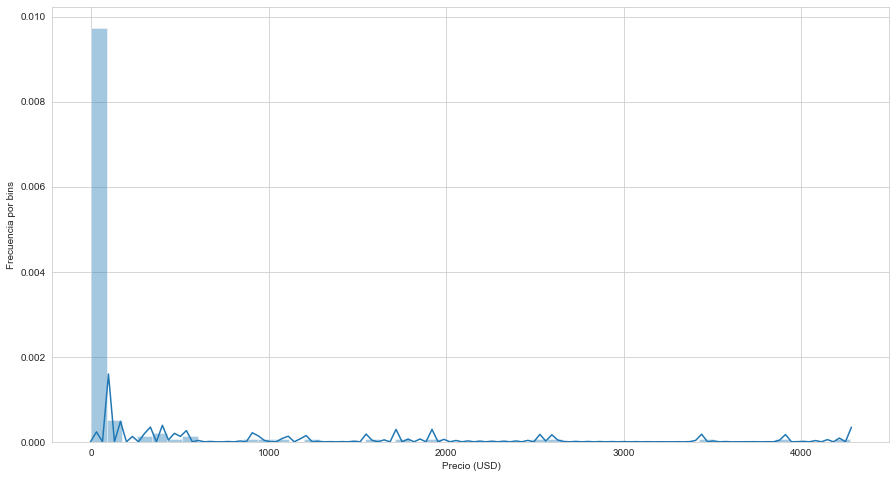

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,8))
ax = sns.distplot(data_games.price.value_counts())
ax.set_xlabel('Precio (USD)')
ax.set_ylabel('Frecuencia por bins')

Conclusión: 

Observamos un sesgo respecto a la distribución de los precios de los juegos, donde la mayoría se encuentra entre 0 y los 30 USD, lo cual es normal para juegos, ya que existen varios juegos que son gratis.

Text(0, 0.5, 'Frecuencia por bins')

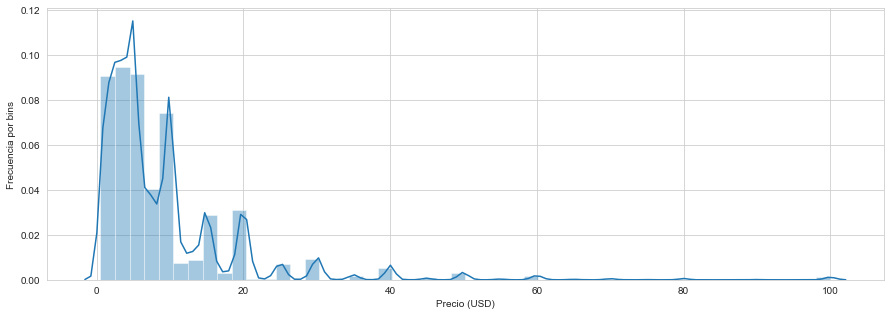

In [42]:
# Excluiremos para este gráfico los valores no numéricos para explorar los precios de los juegos

data_games_filters = data_games.drop(data_games[(data_games.price == 'Free To Play') |
                                         (data_games.price == 'Free to Play') |
                                        (data_games.price == 'Free') |
                                        (data_games.price == 'Free Demo') |
                                        (data_games.price == 'Play for Free!') |
                                        (data_games.price == 'Install Now') |
                                        (data_games.price == 'Play WARMACHINE: Tactics Demo') |
                                        (data_games.price == 'Free Mod') |
                                        (data_games.price == 'Install Theme') |
                                        (data_games.price == 'Third-party') |
                                        (data_games.price == 'Play Now') |
                                        (data_games.price == 'Free HITMAN™ Holiday Pack') |
                                        (data_games.price == 'Play the Demo') |
                                        (data_games.price == 'Starting at $499.00')|
                                        (data_games.price == 'Starting at $449.00') |
                                        (data_games.price == 'Free to Try') |
                                        (data_games.price == 'Free Movie') |
                                        (data_games.price == 'Free To Use') |
                                        (data_games.price == 'Free to Use')].index)

data_games_filters = data_games_filters[data_games_filters.price<=100]
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.distplot(data_games_filters.price)
ax.set_xlabel('Precio (USD)')
ax.set_ylabel('Frecuencia por bins')

Conclusión: 

Podemos observar que los juegos rondan entre un precio que va desde los 0 USD hasta los 60 USD que hace referencia a los juegos más populares o los ultimos lanzamientos. 
También, se puede observar un pequeño outlier que ronda entre los 100 USD, debe hacer referencia a los juegos de edición limitada que son más exclusivos

In [43]:
data_games.isna().sum()


publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

En este dataset podemos observar que hay muchos valores nulos, pero primero para reducir los datos eliminaremos aquellas variables que no son de interes para nuestro análisis.

In [44]:
# Elimino la columna que no usaremos
data_games.drop(columns=['title','publisher','genres','url','release_date','tags','discount_price','reviews_url','specs','price','early_access','developer','sentiment','metascore'], inplace=True)

In [45]:
data_games.head(5)

,app_name,id
0,Lost Summoner Kitty,761140
1,Ironbound,643980
2,Real Pool 3D - Poolians,670290
3,弹炸人2222,767400
4,Log Challenge,773570


In [46]:
data_games.isna().sum()

app_name    2
id          2
dtype: int64

Luego de haber eliminado aquellas variables que no eran de nuestro interes, se puede identificar que solo hay 2 valores nulos en las 2 variables que vamos a utilizar, lo que no afectaran a nuestro analisis ya que no son representativos los valores nulos que poseemos por lo que los eliminaremos.

In [47]:
data_games.dropna(inplace=True)

In [48]:
data_games.isna().sum()


app_name    0
id          0
dtype: int64

Conclusión:
    
Ya no poseemos valores nulos en nuestro dataset

In [49]:
#Renombramos la variable app_name
data_games["product_name"] = data_games.app_name

In [50]:
#Renombramos la variable id
data_games["product_id"] = data_games.id

In [51]:
data_games.drop(columns=['id', 'app_name'], inplace=True)

In [52]:
data_games

,product_name,product_id
0,Lost Summoner Kitty,761140
1,Ironbound,643980
2,Real Pool 3D - Poolians,670290
3,弹炸人2222,767400
4,Log Challenge,773570
...,...,...
32130,Colony On Mars,773640
32131,LOGistICAL: South Africa,733530
32132,Russian Roads,610660
32133,EXIT 2 - Directions,658870


### Cuáles son los juegos más populares? ###



In [53]:
# Los 10 más populares
for i in range(0,9):
    print(data_games[data_games.product_id==str(data_review_filters.product_id.value_counts().index[i])].product_name.values)

['Team Fortress 2']
['Rust']
['Borderlands 2']
['Fallout 4']
['Grand Theft Auto V']
['Undertale']
['Portal 2']
['Warframe']
['DayZ']


### Cuáles son los juegos menos populares? ###

In [54]:
# Los 10 menos populares
for i in range(0,9):
    print(data_games[data_games.product_id==str(data_review_filters.product_id.value_counts(ascending=True).index[i])].product_name.values)

['Dream Hills: Captured Magic']
['Tormented 12']
['Treeker: The Lost Glasses']
['CV Maker for Windows']
['Bathory - The Bloody Countess']
['KEEPER-the hunter of insect']
['WESTSLINGERS']
['Angels That Kill']
['Circularity']


-----

## Parte B: Modelo de Machine Learning ##

In [55]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

In [56]:
# Esta libreria se usa para parsear un archivo de rating que debe tener la forma de user ; item ; rating ; [timestamp] https://surprise.readthedocs.io/en/stable/reader.html

reader = Reader(rating_scale=(1, 10))

In [57]:
#A traves de esta filtración agruparemos los usuarios utilizando el user_id y conocer los product_id que consumieron y que rating obtuvieron

tabla_rating=data_review_filters[['user_id','product_id','rating']].groupby(by='user_id').count()

In [58]:
tabla_rating

,product_id,rating
user_id,,
1,1,1
2,3,3
3,1,1
4,27,27
5,1,1
...,...,...
540337,1,1
540338,1,1
540339,1,1


In [59]:
tabla_rating=tabla_rating[(tabla_rating.product_id>5)]

In [60]:
rating_usuarios=pd.DataFrame(tabla_rating)
rating_usuarios

,product_id,rating
user_id,,
4,27,27
11,30,30
12,13,13
13,7,7
16,63,63
...,...,...
387888,6,6
392638,6,6
403065,6,6


In [61]:
tabla_rating= tabla_rating.rename_axis('user_id').reset_index()


In [62]:
tabla_rating

,user_id,product_id,rating
0,4,27,27
1,11,30,30
2,12,13,13
3,13,7,7
4,16,63,63
...,...,...,...
8957,387888,6,6
8958,392638,6,6
8959,403065,6,6
8960,405132,6,6


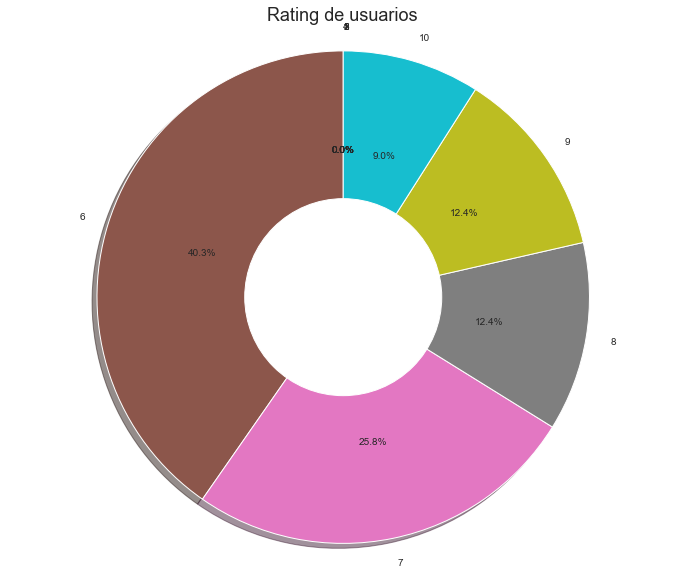

In [63]:
r1=len(tabla_rating[tabla_rating.rating==1])
r2=len(tabla_rating[tabla_rating.rating==2])
r3=len(tabla_rating[tabla_rating.rating==3])
r4=len(tabla_rating[tabla_rating.rating==4])
r5=len(tabla_rating[tabla_rating.rating==5])
r6=len(tabla_rating[tabla_rating.rating==6])
r7=len(tabla_rating[tabla_rating.rating==7])
r8=len(tabla_rating[tabla_rating.rating==9])
r9=len(tabla_rating[tabla_rating.rating==9])
r10=len(tabla_rating[tabla_rating.rating==10])
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [1,2,3,4,5,6,7,8,9,10]
sizes = [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
explode = (0,0,0,0,0,0,0,0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors = ["pink", "lightgreen", "violet", "lightblue", "red", "blue", "green", "yellow", "magenta", "orange"]

fig1, ax1 = plt.subplots(figsize=(12, 10))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Rating de usuarios', fontsize=18)
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


plt.show()

Podemos observar que el 40% esta compuesto por usuarios jugaron menos de 60 horas, seguido en segundo lugar por casi un 26% de usuarios que jugaron menos de 70 horas, seguido en tercer lugar con un 12,4% usuarios que jugaron menos de 80 y 90 horas. Dejando así, un total de 9% de usuarios que jugaron más de 100 horas.

In [64]:
grupo_usuarios=tabla_rating['user_id'].values
data_reviews_final=data_review_filters[data_review_filters.user_id.isin(grupo_usuarios)]
data_reviews_final

,username,product_id,user_id,rating
5,The_Cpt_FROGGY,631920,4,1
6,The_Cpt_FROGGY,482440,4,1
7,The_Cpt_FROGGY,736860,4,1
8,The_Cpt_FROGGY,493540,4,1
9,The_Cpt_FROGGY,341980,4,1
...,...,...,...,...
650193,Zaon,221910,418459,3
650194,Zaon,8930,418459,10
650195,Zaon,285310,418459,4
650196,Zaon,403640,418459,4


In [65]:
data_final = Dataset.load_from_df(data_reviews_final[['user_id', 'product_id', 'rating']], reader)

In [66]:
data_final

## Evaluación del modelo ##

#### A continuación, optimizaremos los paramétros ####

In [67]:
from surprise import SVD
algo = SVD()

In [68]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data_final, measures=['RMSE'], cv = 5, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.5062  2.4842  2.4977  2.4763  2.4852  2.4899  0.0106  
Fit time          1.27    1.31    1.33    1.30    1.29    1.30    0.02    
Test time         0.12    0.13    0.13    0.11    0.12    0.12    0.01    

Número de Factores: 2
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.5298  2.5082  2.5188  2.5026  2.5009  2.5121  0.0109  
Fit time          1.28    1.31    1.38    1.29    1.30    1.31    0.03    
Test time         0.12    0.14    0.12    0.12    0.12    0.12    0.01    

Número de Factores: 4
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.5057  2.5466  2.5222  2.5258  2.5128  2.5226  0.0139  
Fit time          1.34    1.36    

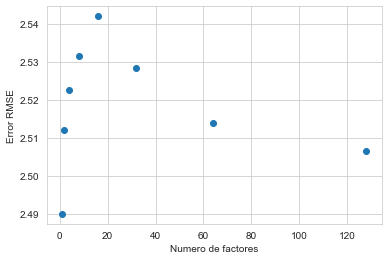

In [69]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [70]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [1,2,4,8,16,32],'n_epochs': [5, 10,20,30], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs = -1)
gs.fit(data_final)

In [71]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

2.4715819049809484
{'n_factors': 1, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.02}


### A continuación utilizaremos los parametros que nos recomendó el GridSearch y luego evaluaremos el modelo ###

In [134]:
trainset, testset = train_test_split(data_final, test_size=0.33)

In [135]:
from surprise import SVD
algo = SVD(n_factors =1,n_epochs=10,lr_all=0.005,reg_all=0.02 )

In [136]:
algo.fit(trainset)

In [137]:
predictions = algo.test(testset)

In [138]:
usuario = 418459
rating = 1 
# Filtramos data_reviews
df_user = data_reviews_final[(data_reviews_final['user_id'] == usuario) & (data_reviews_final['rating'] >= rating)]
#Reseteamos elindex
df_user = df_user.reset_index(drop=True)
# hacemos unjoin df_users y data_games
df_user = pd.merge(left=df_user,right=data_games, left_on='product_id', right_on='product_id')
# Listamos el resultado
df_user

,username,product_id,user_id,rating,product_name
0,Zaon,313160,418459,3,Farming Simulator 15
1,Zaon,221910,418459,3,The Stanley Parable
2,Zaon,8930,418459,10,Sid Meier's Civilization® V
3,Zaon,285310,418459,4,RollerCoaster Tycoon®: Deluxe
4,Zaon,403640,418459,4,Dishonored 2
5,Zaon,391540,418459,10,Undertale


In [139]:
recomendaciones_usuario =data_games.copy()
recomendaciones_usuario.set_index('product_id',inplace=True)
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head(10)

(32132, 1)


,product_name
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,弹炸人2222
773570,Log Challenge
772540,Battle Royale Trainer
774276,SNOW - All Access Basic Pass
774277,SNOW - All Access Pro Pass
774278,SNOW - All Access Legend Pass


In [140]:
usuario_vistas = data_reviews_final[data_reviews_final['user_id'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(6, 4)


,username,product_id,user_id,rating
650192,Zaon,313160,418459,3
650193,Zaon,221910,418459,3
650194,Zaon,8930,418459,10
650195,Zaon,285310,418459,4
650196,Zaon,403640,418459,4


In [141]:
recomendaciones_usuario.drop(usuario_vistas.product_id,inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head(10)

,product_id,product_name
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,Log Challenge
5,772540,Battle Royale Trainer
6,774276,SNOW - All Access Basic Pass
7,774277,SNOW - All Access Pro Pass
8,774278,SNOW - All Access Legend Pass
9,768800,Race


A continuación, el modelo realizará las recomendaciones al usuario elegido

In [142]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)

In [143]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario.head(10)

,product_id,product_name,Estimate_Score
31847,440,Team Fortress 2,8.562291
22837,394360,Hearts of Iron IV,8.450483
58,4000,Garry's Mod,8.123926
387,48700,Mount & Blade: Warband,7.924639
1043,730,Counter-Strike: Global Offensive,7.876459
26948,271590,Grand Theft Auto V,7.817995
30000,107410,Arma 3,7.803824
853,203770,Crusader Kings II,7.797409
25010,377160,Fallout 4,7.679163
29477,39210,FINAL FANTASY XIV Online,7.648279


Podemos observar que en base a los gustos del usuario elegido, el modelo recomienda a este usuario los siguientes juegos con un puntaje estimado que va entre los 7 y 8 puntos con un RMSE de 2.50, por lo que es probable que los juegos recomendados sean de interes para el usuario .

In [144]:
from surprise import accuracy

rmse_svd_1 = accuracy.rmse(predictions)

RMSE: 2.4920


### A continuación, filtraremos el dataset con los juegos que tienen un rating menor a 5 y evaluaremos nuevamente el modelo ###

In [97]:
data_filtrada=data_review_filters[['user_id','product_id','rating']].groupby(by='user_id').count()
data_filtrada=data_filtrada[(data_filtrada.rating<5) ]
data_filterada_usuarios=pd.DataFrame(data_filtrada)
data_filtrada= data_filtrada.rename_axis('user_id').reset_index()
grupo_usuarios=data_filtrada['user_id'].values
data_reviews_filtrado=data_review_filters[data_review_filters.user_id.isin(grupo_usuarios) ]

In [98]:
data_reviews_filtrado.shape

(658657, 4)

In [99]:
data_reviews_filtrado=data_reviews_filtrado.loc[(data_reviews_filtrado['rating'] > 5 )]

In [100]:
data_reviews_filtrado.shape

(182708, 4)

In [101]:
data_reviews_filtrado.head(5)

,username,product_id,user_id,rating
328,Violence,393380,36,10
329,Violence,227300,36,10
357,anotherphysicsgradstudent,35140,39,6
363,Venny,372000,40,7
372,BlackSmoke,365560,42,10


In [102]:
data = Dataset.load_from_df(data_reviews_filtrado[['user_id', 'product_id', 'rating']], reader)

### A continuación, optimizaremos los parametros y evaluaremos nuevamente el modelo ###

In [90]:
algo = SVD()

In [91]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [1,2,4,8,16,32],'n_epochs': [5, 10,20,30], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs = -1)
gs.fit(data)

In [92]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.2905347350188001
{'n_factors': 32, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.002}


### A continuación utilizaremos los parametros que nos recomendó el GridSearch y luego evaluaremos el modelo ###

In [117]:
trainset, testset = train_test_split(data, test_size=0.33)

In [118]:
from surprise import SVD
algo = SVD(n_factors =32,n_epochs=30,lr_all=0.005,reg_all=0.002 ) 

In [119]:
algo.fit(trainset)

In [120]:
predictions = algo.test(testset)

In [121]:
# Seleccionamos el mismo usuario que en el ejemplo anterior
usuario = 418459
rating = 1 
# Filtramos data_reviews
df_user = data_reviews_filtrado[(data_reviews_filtrado['user_id'] == usuario) & (data_reviews_filtrado['rating'] >= rating)]
#Reseteamos elindex
df_user = df_user.reset_index(drop=True)
# hacemos unjoin df_users y data_games
df_user = pd.merge(left=df_user,right=data_games, left_on='product_id', right_on='product_id')

In [122]:
recomendaciones_usuario =data_games.copy()
recomendaciones_usuario.set_index('product_id',inplace=True)
usuario_vistas = data_reviews_filtrado[data_reviews_filtrado['user_id'] == usuario]
recomendaciones_usuario.drop(usuario_vistas.product_id,inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)
recomendaciones_usuario.head(10)

,product_id,product_name,Estimate_Score
0,761140,Lost Summoner Kitty,9.152760
1,643980,Ironbound,9.103353
2,670290,Real Pool 3D - Poolians,9.152760
3,767400,弹炸人2222,9.152760
4,773570,Log Challenge,9.152760
5,772540,Battle Royale Trainer,9.152760
6,774276,SNOW - All Access Basic Pass,9.152760
7,774277,SNOW - All Access Pro Pass,9.152760
8,774278,SNOW - All Access Legend Pass,9.152760
9,768800,Race,9.152760


In [123]:
from surprise import accuracy

rmse_svd_2 = accuracy.rmse(predictions)

RMSE: 1.2943


Podemos observar que en base a los gustos del usuario elegido, el modelo esta vez tiene una mejor performance en comparación al anterior ya que recomienda juegos con un puntaje de 9.15 puntos con un RMSE de 1.29, por lo que es probable que los juegos recomendados sean de interes para el usuario.

## Comparando resultados de Ambos Modelos ##

(array([0, 1]), [Text(0, 0, 'SVD_1'), Text(1, 0, 'SVD_2')])

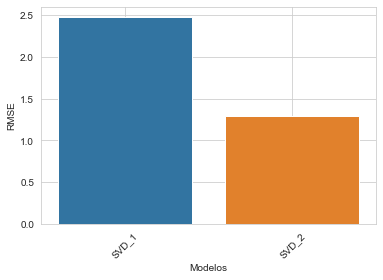

In [105]:
errores = {
    'Modelos': ['SVD_1', 'SVD_2'],
    
    'RMSE': [rmse_svd_1, rmse_svd_2]}

tabla_errores = pd.DataFrame(errores, columns = ['Modelos', 'RMSE'])

sns.barplot(x = 'Modelos', y = 'RMSE', data = tabla_errores)
plt.grid('y')
plt.xticks(rotation = 45)

Conclusión:

Podemos observar que el segundo modelo tiene una mejor performance en comparación al primero, ya que el RMSE se redujo notablemente. 

Quedo demostrado que filtrando el dataset con los juegos que poseen un rating mayor a 5 el modelo fue más  eficiente y tuvo una mejor precisión a la hora de recomendar juegos.

---

### Parte C: Investigación ###

A través de nuestro análisis, pudimos determinar en base a los guston de los usuarios, diversos juegos para recomendarles que podrian gustarles. Para obtener esta información utilizamos la variable "hours" con la cual creamos una nueva columna llamada "rating" para determinar cuales fueron los juegos que más le gustaron a los usuario y asi poder predecir juegos que posiblemente le gustaran. 

Si bien el modelo que funcionó mejor fue en el cual filtramos el dataset quedandonos solamente con los juegos que tenian un rating mayor a 5. El modelo no solo reducio su error y fue más preciso que al anterior, sino que puntajes estimados de los juegos recomendados poseian un puntaje de 9.15 lo que significa que probablemente las recomendaciones sean de interes para el usuario seleccionado.

## ¿Qué podemos mejorar? ##

Existen cierto atributos que podriamos utilizar para mejorar la precisión de nuestro modelo, ya que nos brindarian más información acerca de los gustos, generos, modalidades de juegos preferidas a cerca de los usuarios, lo cuál serian beneficiosos para nuestro modelo ya que mejorarian la precisión y efectividad del mismo a la hora de recomendarle juegos a los usuarios.

Combinando los dataset reviews y games, podemos identificar atributos como los tags o specs que con ellos se podrían identificar los generos del juego así como tambien el tipo de modalidad la cual puede ser single player o multijugador. Combinando este tipo de información junto con los datos del dataset review podremos inferir no solo en los gustos del usuario sino tambien en el genero y modalidad de juego preferida y a partir de eso, se podría pensar en algun tipo de modelo más complejo y así mejorar la precisión del modelo.

### REVIEWS ###

In [124]:
data_reviews_parteC.head(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,NaN


In [125]:
data_text = data_reviews_parteC[['product_id', 'text']]

In [126]:
data_text

,product_id,text
0,725280,This would not be acceptable as an entertainme...
1,328100,Addictive RPG ! Works fine on linux though it ...
2,725280,Прикольная стрелялка. Взял дешево на распродаже.
3,631920,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...
4,35140,"This game was way to linear for me, and compar..."
...,...,...
779302,252490,Summary: Rust is a survival game created by Fa...
779303,252490,Coolest Game Eva
779304,252490,Should you buy RUST? Uh... YES. The BEST Survi...
779305,252490,Great game!


### GAMES ###

In [127]:
data_games_parteC.head(5)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [128]:
data_tags = data_games_parteC[['app_name', 'tags', 'specs']]

In [129]:
data_tags

,app_name,tags,specs
0,Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player]
1,Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla..."
2,Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla..."
3,弹炸人2222,"[Action, Adventure, Casual]",[Single-player]
4,Log Challenge,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V..."
...,...,...,...
32130,Colony On Mars,"[Strategy, Indie, Casual, Simulation]","[Single-player, Steam Achievements]"
32131,LOGistICAL: South Africa,"[Strategy, Indie, Casual]","[Single-player, Steam Achievements, Steam Clou..."
32132,Russian Roads,"[Indie, Simulation, Racing]","[Single-player, Steam Achievements, Steam Trad..."
32133,EXIT 2 - Directions,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...","[Single-player, Steam Achievements, Steam Cloud]"
